### Time Series Forecasting with SARIMA (Autoregressive Integrated Moving Average)

Collect Google stock price data using the Yahoo Finance API.

In [1]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 25.9 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 3.6 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.3-cp310-cp310-linux_x86_64.whl size=293152 sha256=2d2410da22765cc51d8a6b20004a5550d86bac4ec3a325031d6087e46199be24
  Stored in directory: /root/.cache/pip/wheels/0d/32/b7/cad9f818b37cf97df4c87a8308da86a433af81651d98f8d8aa
Successfully built peewee


In [2]:
import yfinance as yf

import pandas as pd
import matplotlib.pyplot as plt

import datetime
from datetime import date, timedelta

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller #ADF Test
from statsmodels.tsa.stattools import kpss  #KPSS Test
from statsmodels.graphics.tsaplots import plot_pacf

import warnings

In [3]:
today = date.today()

# end date
d1 = today.strftime("%Y-%m-%d")
end_date = d1

# start date
d2 = date.today() - timedelta(days=365)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2

# download data
data = yf.download('GOOG', 
                      start=start_date, 
                      end=end_date, 
                      progress=False)

In [4]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-04-18,107.000000,107.050003,104.779999,105.120003,105.120003,17641400
2023-04-19,104.214996,105.724998,103.800003,105.019997,105.019997,16732000
2023-04-20,104.650002,106.888000,104.639999,105.900002,105.900002,22515300
2023-04-21,106.089996,106.639999,105.485001,105.910004,105.910004,22379000
2023-04-24,106.050003,107.320000,105.360001,106.779999,106.779999,21410900
...,...,...,...,...,...,...
2024-04-10,157.880005,158.160004,156.199997,157.660004,157.660004,16339200
2024-04-11,158.339996,161.119995,157.929993,160.789993,160.789993,17841700
2024-04-12,159.404999,161.699997,158.600006,159.190002,159.190002,16968200


In [5]:
data["Date"] = data.index

data = data[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]
data.reset_index(drop=True, inplace=True)

data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
246,2024-04-10,157.880005,158.160004,156.199997,157.660004,157.660004,16339200
247,2024-04-11,158.339996,161.119995,157.929993,160.789993,160.789993,17841700
248,2024-04-12,159.404999,161.699997,158.600006,159.190002,159.190002,16968200
249,2024-04-15,160.279999,160.830002,156.149994,156.330002,156.330002,21140900
250,2024-04-16,155.639999,157.229996,155.050003,156.000000,156.000000,15404000


We only need the date and close prices columns for the rest of the task, so let’s select both the columns and move further:

In [6]:
data = data[['Date', 'Close']]
data.head()

,Date,Close
0,2023-04-18,105.120003
1,2023-04-19,105.019997
2,2023-04-20,105.900002
3,2023-04-21,105.910004
4,2023-04-24,106.779999


Now let’s visualize the close prices of Google before moving forward:

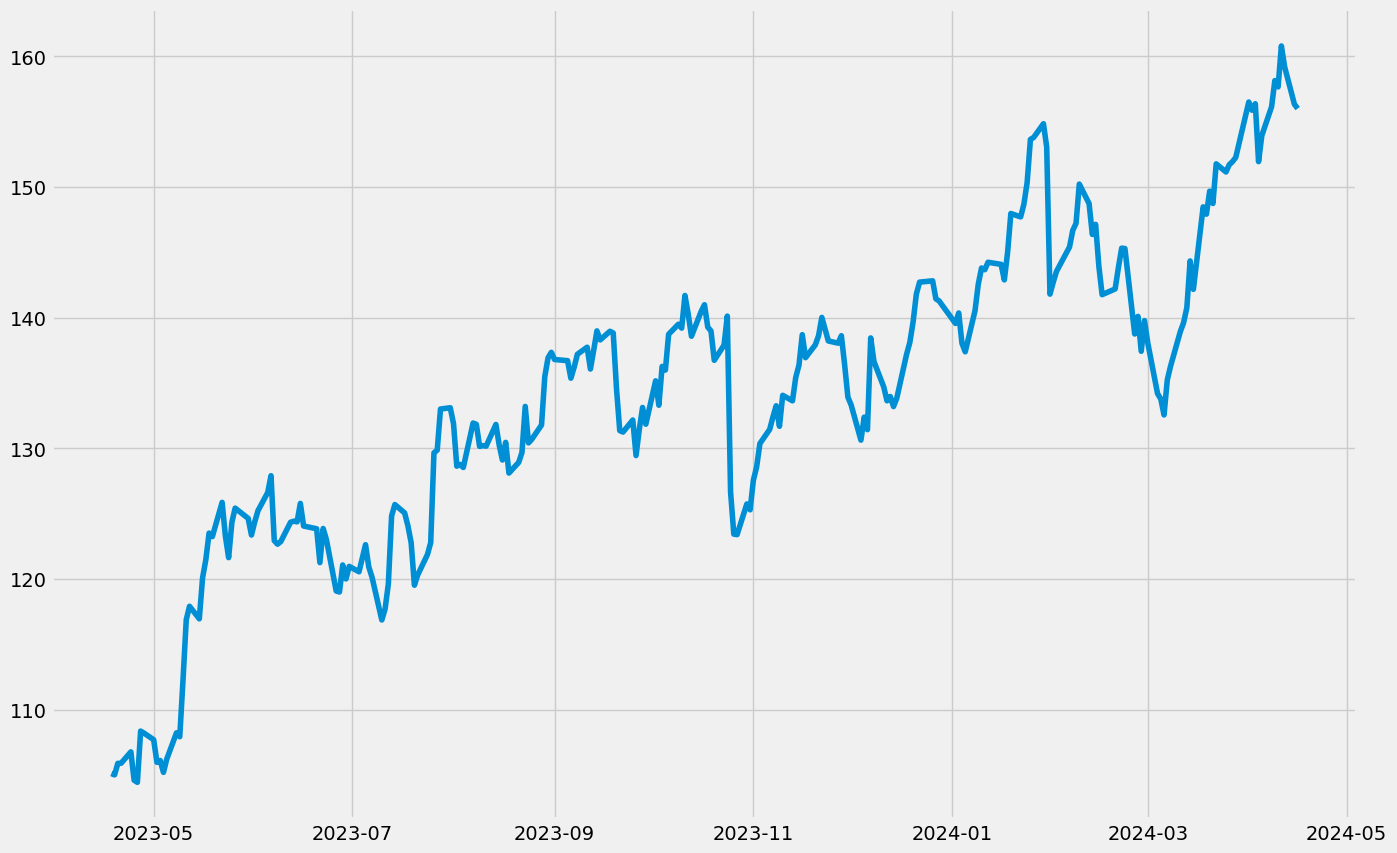

In [7]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 10))
plt.plot(data["Date"], data["Close"])

### Using ARIMA for Time Series Forecasting

Before using the ARIMA model, we have to figure out whether our data is **stationary or seasonal**.

The data visualization graph about the closing stock prices above shows that our dataset is not stationary. 
To check whether our dataset is stationary or seasonal properly, we can use the **seasonal decomposition** method that splits the time series data into trend, seasonal, and residuals for a better understanding of the time series data:

<Figure size 640x480 with 0 Axes>

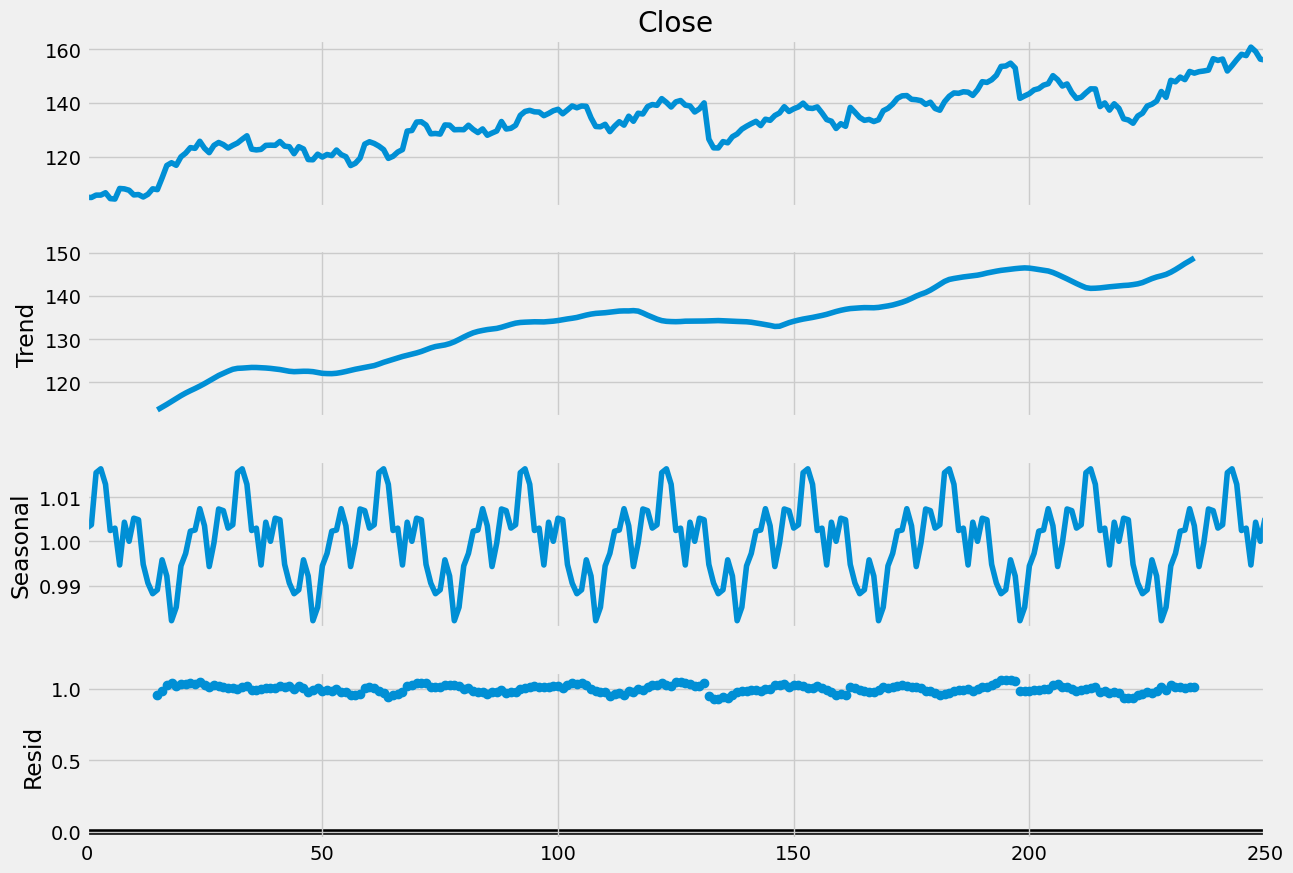

In [8]:
result = seasonal_decompose(data["Close"], model='multiplicative', period=30 )
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 10)

> So our data is not stationary it is seasonal. 

### Augmented Dickey-Fuller (ADF) Test

ADF test is conducted with the following assumptions:

Null Hypothesis (HO): Series is non-stationary, or series has a unit root.
Alternate Hypothesis(HA): Series is stationary, or series has no unit root.
If the null hypothesis is failed to be rejected, this test may provide evidence that the series is non-stationary.

Conditions to Reject Null Hypothesis(HO)

If Test statistic < Critical Value and p-value < 0.05 – Reject Null Hypothesis(HO), i.e., time series does not have a unit root, meaning it is stationary. It does not have a time-dependent structure.

In [9]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
# Call the function and run the test

adf_test(data['Close'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.869213
p-value                          0.346680
#Lags Used                       0.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


> Data is non-stationary

### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test

The KPSS test is conducted with the following assumptions.

Null Hypothesis (HO): Series is trend stationary or series has no unit root.
Alternate Hypothesis(HA): Series is non-stationary, or series has a unit root.
Note: The hypothesis is reversed in the KPSS test compared to ADF Test.

If the null hypothesis is failed to be rejected, this test may provide evidence that the series is trend stationary.

Conditions to Fail to Reject Null Hypothesis(HO)

If the Test Statistic < Critical Value and p-value < 0.05 – Fail to Reject Null Hypothesis(HO), i.e., time series does not have a unit root, meaning it is trend stationary.

So practically, the interpretation of p-value is just the opposite of each other.

In [10]:
from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    
kpss_test(data['Close'])

Results of KPSS Test:
Test Statistic            1.979398
p-value                   0.010000
#Lags Used               10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/tmp/ipykernel_18/3469517202.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression='c', nlags="auto")


> Data is non-stationary

If the data is stationary, we need to use ARIMA, if the data is seasonal, we need to use Seasonal ARIMA (SARIMA)

We need to use the **Seasonal ARIMA (SARIMA) model** for Time Series Forecasting on this data.

To use ARIMA or SARIMA, we need to find the p, d, and q values:

* We can find the value of p by plotting the autocorrelation of the Close column and the value of q by plotting the partial autocorrelation plot. 
* The value of d is either 0 or 1. If the data is stationary, we should use 0, and if the data is seasonal, we should use 1. As our data is seasonal, we should use 1 as the d value.

Now here’s how to find the value of p:

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

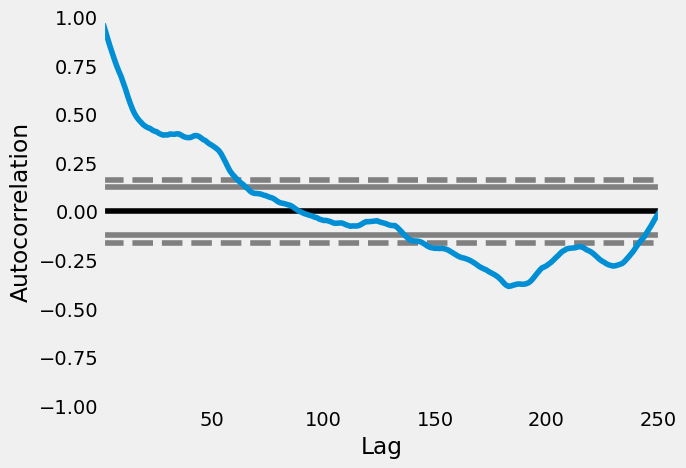

In [11]:
pd.plotting.autocorrelation_plot(data["Close"])

>In the above autocorrelation plot, the curve is moving down after the 5th line of the first boundary. That is how to decide the p-value. Hence the value of p is 5. Now let’s find the value of q (moving average):

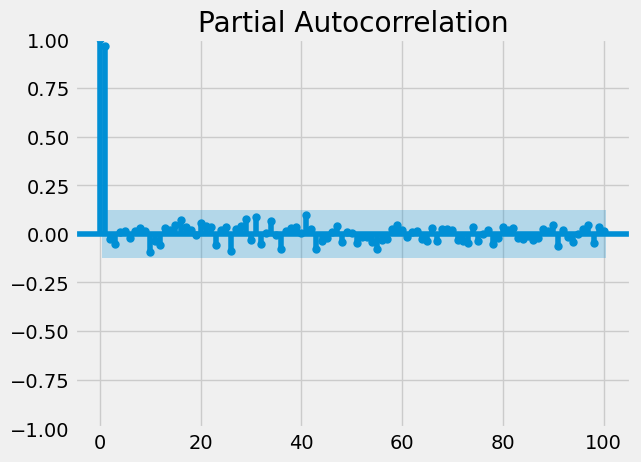

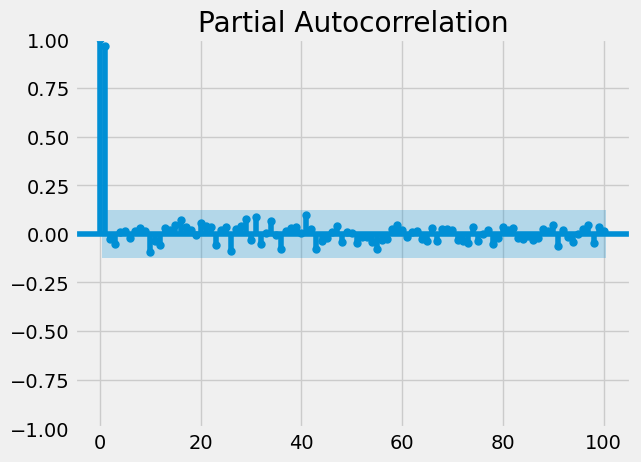

In [12]:
plot_pacf(data["Close"], lags = 100)

> In the above partial autocorrelation plot, we can see that only two points are far away from all the points. That is how to decide the q value. Hence the value of q is 2.

In [13]:
p, d, q = 5, 1, 2

model=sm.tsa.statespace.SARIMAX(data['Close'],
                                order=(p, d, q),
                                seasonal_order=(p, d, q, 12))
model=model.fit()
model.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.30514D+00    |proj g|=  1.96314D-01


 This problem is unconstrained.



At iterate    5    f=  2.22360D+00    |proj g|=  1.41075D-01

At iterate   10    f=  2.20996D+00    |proj g|=  2.75253D-02

At iterate   15    f=  2.19031D+00    |proj g|=  3.01435D-02

At iterate   20    f=  2.18509D+00    |proj g|=  2.04041D-02

At iterate   25    f=  2.18329D+00    |proj g|=  2.57507D-03

At iterate   30    f=  2.18161D+00    |proj g|=  3.11588D-02

At iterate   35    f=  2.17872D+00    |proj g|=  1.52175D-02

At iterate   40    f=  2.17828D+00    |proj g|=  6.57613D-03

At iterate   45    f=  2.17763D+00    |proj g|=  5.66180D-02

At iterate   50    f=  2.17753D+00    |proj g|=  2.64461D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                  251
Model:             SARIMAX(5, 1, 2)x(5, 1, 2, 12)   Log Likelihood                -546.561
Date:                            Wed, 17 Apr 2024   AIC                           1123.122
Time:                                    15:48:34   BIC                           1175.206
Sample:                                         0   HQIC                          1144.113
                                            - 251                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3331      0.088      3.769      0.000       0.160       0.506
ar.L2         -0.9294      0.095     -9.814      0.000      -1.115      -0.744
ar.L3         -0.0713      0.117     -0.611      0.541      -0.300       0.157
ar.L4          0.0900      0.091      0.994      0.320      -0.087       0.267
ar.L5         -0.1103      0.088     -1.260      0.208      -0.282       0.061
ma.L1         -0.3131      0.039     -8.040      0.000      -0.389      -0.237
ma.L2          0.9767      0.048     20.436      0.000       0.883       1.070
ar.S.L12      -1.1298     48.329     -0.023      0.981     -95.853      93.594
ar.S.L24      -0.1669      6.367     -0.026      0.979     -12.646      12.313
ar.S.L36      -0.1705      1.718     -0.099      0.921      -3.539       3.198
ar.S.L48      -0.2460      6.528     -0.038      0.970     -13.041      12.549
ar.S.L60      -0.1109      5.414     -0.020      0.984     -10.722      10.500
ma.S.L12      -0.0018    148.393   -1.2e-05      1.000    -290.846     290.843
ma.S.L24      -0.9982    149.760     -0.007      0.995    -294.522     292.525
sigma2         4.7905    675.718      0.007      0.994   -1319.592    1329.173
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               444.56
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                            -0.85
Prob(H) (two-sided):                  0.15   Kurtosis:                         9.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Now let’s predict the future stock prices using the SARIMA model for the next 10 days:

In [14]:
predictions = model.predict(len(data), len(data)+10)
print(predictions)

251    156.058743
252    155.885839
253    155.184827
254    156.003305
255    156.223231
256    158.135645
257    158.569515
258    158.055432
259    157.739918
260    158.482680
261    159.691387
Name: predicted_mean, dtype: float64


Lets plot the predictions:

<Axes: >

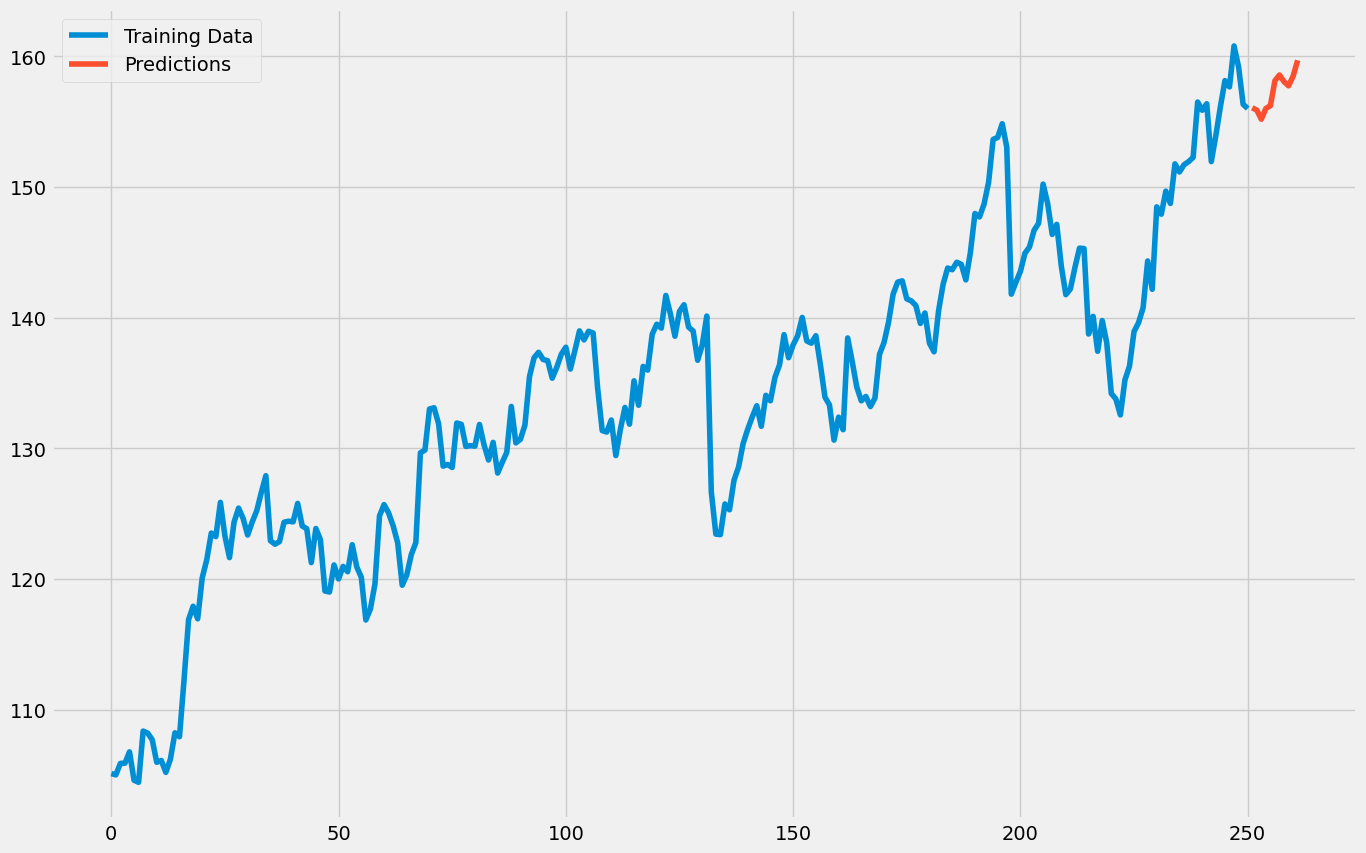

In [15]:
data["Close"].plot(legend=True, label="Training Data", figsize=(15, 10))
predictions.plot(legend=True, label="Predictions")